## Import packages and definitions

In [4]:
import re
import os
import random
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from pyathena import connect
import boto3
from botocore.exceptions import ClientError
import openai
from openai import OpenAI
import json
import math
from scipy.stats import zscore
import pyarrow.parquet as pq

%matplotlib inline
sns.set_theme()

In [5]:
def get_secret(api_key_name):
    secret_name = "AmazonSageMaker-sagemarker_yuwen"
    region_name = "us-east-1"

    # Create a Secrets Manager client
    session = boto3.session.Session()
    client = session.client(
        service_name='secretsmanager',
        region_name=region_name
    )

    try:
        get_secret_value_response = client.get_secret_value(
            SecretId=secret_name
        )
    except ClientError as e:
        # For a list of exceptions thrown, see
        # https://docs.aws.amazon.com/secretsmanager/latest/apireference/API_GetSecretValue.html
        raise e

    secret = get_secret_value_response['SecretString']
    
    return json.loads(secret)[api_key_name]

In [16]:
def load_s3_parquet(file):
    file_identifier = "s3://"
    bucket_name = "trepp-developmentservices-datascience/"
    prefix = "llm-exploration/treppwire_rag/"
    
    s3_path = file_identifier + bucket_name + prefix + file
    return pq.read_table(s3_path).to_pandas()

In [7]:
def get_completion(message, model='gpt-3.5-turbo-0125', seed=12345, temperature=0, tools=None): # max_tokens
    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "system",
                "content": "You are helpful assistant.",
            },
            {"role": "user", "content": message},
        ],
        temperature=temperature,
        # max_tokens=max_tokens,
        seed=seed,
        top_p=1,
        frequency_penalty=0,
        presence_penalty=0 # seed=1001
)
    
    return response # response_format={ "type": "json_object"}, designed to output JSON

In [8]:
def list_of_word_len(x): # x is the series
    return [len(text.split()) for text in x.tolist()]

def avg_count(x): # x is the series of plaintext
     return sum(list_of_word_len(x))/len(x)

In [9]:
# Creating an array of json tasks
def generate_tasks(df, task_file_name, model='gpt-3.5-turbo-0125', seed=12345, temperature=0):
    tasks = []

    for i in tqdm(range(len(df))):
        context = df.iloc[i,:].summaryplaintext

        message = prompt7.format(context=context)

        task = {
            "custom_id": f"task-{i}",
            "method": "POST",
            "url": "/v1/chat/completions",
            "body": {
                # This is what you would have in your Chat Completions API call
                "model": model,
                "messages": [
                    {
                        "role": "system",
                        "content": "You are helpful assistant.",
                    },
                    {"role": "user", "content": message},
                ],
                "response_format": {"type":"json_object"},
                "temperature": temperature,
                "seed": seed,
                "top_p": 1,
                "frequency_penalty": 0,
                "presence_penalty":0 # seed=1001
            }
        }
        tasks.append(task)
    
    # Creating the file

    # task_file_name = "./batch_tasks_movies.jsonl"

    with open(task_file_name, 'w') as file:
        for obj in tasks:
            file.write(json.dumps(obj) + '\n')
            
    batch_file = client.files.create(
        file=open(task_file_name, "rb"),
        purpose="batch"
    ) # check status
    
    return batch_file


def create_batch_job(batch_file):
    # create batch job
    batch_job = client.batches.create(
      input_file_id=batch_file.id,
      endpoint="/v1/chat/completions",
      completion_window="24h"
    )
    
    # batch_job = client.batches.retrieve(batch_job.id)
    
    return batch_job

# def check_batch_job_status(batch_job):
    

def retrieve_results(batch_job, output_file_name):
    result_file_id = batch_job.output_file_id
    result = client.files.content(result_file_id).content

    with open(output_file_name, 'wb') as file:
        file.write(result)

            
def reading_results(output_file_name):
    # Loading data from saved file
    results = []
    with open(output_file_name, 'r') as file:
        for line in file:
            # Parsing the JSON string into a dict and appending to the list of results
            json_object = json.loads(line.strip())
            results.append(json_object)
    
    # get multi-stories flag and table flag
    multi_story_flag, tb_flag, num_of_input, num_of_output = [], [], 0, 0

    for res in tqdm(results):
        result = res['response']['body']['choices'][0]['message']['content']
        result = json.loads(result)
        
        num_of_input += res['response']['body']['usage']['prompt_tokens']
        num_of_output += res['response']['body']['usage']['completion_tokens']

        multi_story_flag.append(result['containing_multiple_stories'])
        tb_flag.append(result["containing_table"])
    
    return multi_story_flag, tb_flag, num_of_input, num_of_output

## Prompt templates

In [10]:
prompt1 = '''
    I want you to do step by step:
    1. First understand in a clear and readable way of the context (without any changes, removal, or summarization!!!) 
    2. Then find the number of stories in the context, there may be several situations: Each independent story normally has a title and context and representing a specific property.
    3. If the context has tables, set the flag of having table as <True>.
    4. Output the stories and the number of stories in JSON format like this:
        {{
            "context": 
                [{{
                    "title": <title>,
                    "content": <context without any change>
                }}],
            "number_of_stories": <number of stories>,
            "containing_table": <True or False>
        }}
    context: {context} 
    If the context is too long and you cannot accurately process it, you can just output: 
        {{
            "context": 
                [{{
                    "title": <None>,
                    "content": <The text you provided is too long for me to process in one response.>
                }}],
            "number_of_stories": <infinity>
            "containing_table": <infinity>
        }}
    Answer: 
    
    Do not wrap the json codes in JSON markers
'''

prompt2 = '''
    I want you to do step by step:
    1. First understand in a clear and readable way of the context (without any changes, removal, or summarization!!!) 
    2. Then find the number of stories in the context, there may be several situations: Each independent story normally has a title and context and representing a specific property.
    3. If the context has tables, set the flag of having table as <True>.
    4. Output the stories and the number of stories in JSON format like this:
        {{
            "context": 
                [{{
                    "title": <title>,
                    "content": <context without any change>
                }}],
            "containing_table": <True or False>
        }}
    context: {context}
    Answer:
    
    Do not wrap the json codes in JSON markers
'''

prompt3 = '''
    I want you to do step by step:
    1. First understand in a clear and readable way of the context (without any changes, removal, or summarization!!!) 
    2. Then find the number of stories in the context, there may be several situations: Each independent story normally has a title and context and representing a specific property.
    3. If the context has tables, set the flag of having table as <True>; if not, set the flag as <False>. Tables are typically characterized by rows and columns of data, often separated by spaces, commas, or other delimiters. Look for repeated patterns and alignments that suggest tabular data.
    4. Output the stories and the number of stories in JSON format like this:
        {{
            "context": 
                [{{
                    "title": <title>,
                    "content": <context without any change>
                }}],
            "containing_table": <True or False>
        }}
    context: {context}
    Answer:
    
    Do not wrap the json codes in JSON markers
'''

prompt4 = '''
    I want you to do step by step:
    1. First understand in a clear and readable way of the context (without any changes, removal, or summarization!!!) 
    2. Then find the number of stories in the context: Each independent story normally has a title and context and representing a specific property.
    3. If the context has tables, set the flag of having table as <True>; if not, set the flag as <False>. Tables are typically characterized by rows and columns of data, often separated by spaces, commas, or other delimiters. Look for repeated patterns and alignments that suggest tabular data.
    4. Output the stories and the number of stories in JSON format like this:
        {{
            "context": 
                [{{
                    "title": <title>,
                    "content": <context without any change>
                }}],
            "containing_table": <True or False>
        }}
    context: {context}
    Answer:
    
    Do not wrap the json codes in JSON markers
'''


prompt5 = '''
    I want you to do step by step:
    1. First understand the context in a clear and readable way (without any changes, removal, or summarization!!!).
    2. Then find the number of stories in the context: Each independent story normally has a title and context and represents a specific property.
    3. If the context has tables, set the flag of having table as <True>; if not, set the flag as <False>. 
       Tables are typically characterized by:
       - Rows and columns of data, often separated by spaces, commas, or other delimiters.
       - Repeated patterns and alignments that suggest tabular data.
       - Presence of numerical data or dates in a structured format.
       - Consistent formatting such as aligned columns or rows that are structured in a grid-like format.
       - Column headers that define the type of data in each column.
       - Large blocks of numbers with similar formatting often indicate a table.
    4. Output the stories and the number of stories in JSON format like this:
        {{
            "context": 
                [{{
                    "title": "<title>",
                    "content": "<context without any change>"
                }}],
            "containing_table": <True or False>
        }}
    context: {context}
    Answer:
    
    Do not wrap the json codes in JSON markers
''' # best prompt for outputing context and table flag.

prompt6 = '''
    I want you to do the following step by step:
    1. First, read and understand the context fully and clearly (without making any changes, removal, or summarization). Internally store this context for reference in the subsequent steps.
    2. Determine the number of stories in the context: Each independent story normally has a title and context and represents a specific property.
    3. If the number of stories in the context is larger than 1, set the flag of having multiple stories as <True>; if there is only one story, set the flag as <False>.
    4. Check if the context contains tables. Tables are typically characterized by:
       - Rows and columns of data, often separated by spaces, commas, or other delimiters.
       - Repeated patterns and alignments that suggest tabular data.
       - Presence of numerical data or dates in a structured format.
       - Consistent formatting such as aligned columns or rows that are structured in a grid-like format.
       - Column headers that define the type of data in each column.
       - Large blocks of numbers with similar formatting often indicate a table.
       Set the flag of having a table as <True> if any tables are present; otherwise, set it as <False>.
    5. Output only the following in JSON format:
       {{
           "containing_multiple_stories": <True or False>,
           "containing_table": <True or False>
       }}

    Context given: {context}
    Answer:
    
    Do not wrap the JSON output in JSON markers.
    Do not include any other text or information besides the specified JSON output.
'''


prompt7 = '''
    I want you to do the following step by step:
    1. First, read and fully understand the context clearly (without making any changes, removal, or summarization). Internally store this context for reference in the subsequent steps.
    2. Determine the number of stories in the context: Each independent story normally has a title and context and represents a specific property.
    3. If the number of stories in the context is larger than 1, set the flag of having multiple stories as <True>; if there is only one story, set the flag as <False>.
    4. Check if the context contains tables. Tables are typically characterized by:
       - Rows and columns of data, often separated by spaces, commas, or other delimiters.
       - Repeated patterns and alignments that suggest tabular data.
       - Presence of numerical data or dates in a structured format.
       - Consistent formatting such as aligned columns or rows that are structured in a grid-like format.
       - Column headers that define the type of data in each column.
       - Large blocks of numbers with similar formatting often indicate a table.
       Set the flag of having a table as <True> if any tables are present; otherwise, set it as <False>.
    5. Let's think this through step by step to ensure accuracy. Finally, output only the following in JSON format:
       {{
           "containing_multiple_stories": <True or False>,
           "containing_table": <True or False>
       }}

    Context given: {context}
    Answer:
    
    Do not wrap the JSON output in JSON markers.
    Do not include any other text or information besides the specified JSON output.
''' # best prompt for output mutiple stories flag and table flag.



prompt8 = '''
    I want you to do step by step:
    1. First understand the context in a clear and readable way (without any changes, removal, or summarization!!!).
    2. Then find the number of stories in the context: Each independent story normally has a title and context and represents a specific property.
    3. If the context has tables, set the flag of having table as <True>; if not, set the flag as <False>. 
       Tables are typically characterized by:
       - Rows and columns of data, often separated by spaces, commas, or other delimiters.
       - Repeated patterns and alignments that suggest tabular data.
       - Presence of numerical data or dates in a structured format.
       - Consistent formatting such as aligned columns or rows that are structured in a grid-like format.
       - Column headers that define the type of data in each column.
       - Large blocks of numbers with similar formatting often indicate a table.
    4. Output the stories and the number of stories in JSON format like this:
        {{
            "context": 
                [{{
                    "title": "<title>"
                }}],
            "containing_table": <True or False>
        }}
    context: {context}
    Answer:
    
    Do not wrap the json codes in JSON markers
'''

## Initialize openai gpt

In [11]:
# API key setting
os.environ["OPENAI_API_KEY"] = get_secret("OPENAI_API_KEY")
# Clients setting
client = OpenAI()

## Import data

In [12]:
# conn = connect(
#     s3_staging_dir='s3://trepp-developmentservices-lake-athena/ds/',
#     region_name='us-east-1')

In [13]:
# SQL = """
# SELECT *
# FROM "presentation_dev"."treppwirecreditstories" 
# WHERE 
#     authorname IS NOT NULL
#     and
#     authorname != ' '
#     and 
#     SUBSTR(publishdate, 1, 4) >= '2019';
# """

# tpwire = pd.read_sql(SQL, conn)

In [14]:
# tpwire.to_parquet('treppwire_stories.parquet')

In [11]:
# tpwire = pd.read_parquet('treppwire_stories.parquet')
tpwire = load_s3_parquet('treppwire_stories.parquet')
tpwire

,creditstoriesid,postid,authoremail,authorname,contentsource,contenttype,dealname,htmlcontent,summaryplaintext,loanid,...,propertysubtype,propsubtypecode,proptypecode,state,county,city,msaname,loanname,region,publishdate
0,609386dc86f2df503086dcceef93c9300e0eb97e23dd6d...,55990,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[UBSBB 2013-C6],<h4><strong>379-Unit Apartment Community in Sa...,379-Unit Apartment Community in San Diego Sold...,[319004],...,[Flex / R&D],[Office],[OF],[PA],[Washington],[Canonsburg],"[Pittsburgh, PA]",[701 Technology Drive],[Middle Atlantic],2022-12-21T06:35:33
1,a244c33053ebd629538df7addfdd7846c3f154a804a461...,56518,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[WFRBS 2014-C20],<h4>Denver Office Misses Balloon Date – Note S...,Denver Office Misses Balloon Date – Note Sent ...,[341601],...,[Suburban Office],[Office],[OF],[TX],[Fort Bend],[Sugar Land],"[Houston-The Woodlands-Sugar Land, TX]","[Sugar Creek I, Sugar Creek II]",[West South Central],2023-09-18T09:27:20
2,713bc661ed6e8aad6987dbf54d0f41a6881847e382b04e...,56147,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[UBSBM 2012-WRM],<h4><strong>TreppWire News Flash: New Special ...,TreppWire News Flash: New Special Servicer Com...,[338547],...,[Mixed Use],[Mixed Use],[MU],[GA],[Fulton],[Atlanta],"[Atlanta-Sandy Springs-Roswell, GA]",[Biltmore Office],[South Atlantic],2023-03-13T06:30:56
3,22a75dc8781ff52b1cd2994b35b35a64bff0482d681d70...,56384,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[OMPT 2017-1MKT],<h4><strong>Big TX Retail Loan Paid Off</stron...,Big TX Retail Loan Paid OffJuly remittance dat...,[398221],...,[Urban Office],[Office],[OF],[CA],[San Francisco],[San Francisco],"[San Francisco-Oakland-Hayward, CA]",[One Market Plaza],[Pacific],2023-07-20T09:33:49
4,1ae4bebc08a10939c40e4ecf663897f107600c3e58361e...,55950,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[CSAIL 2018-C14],<h4><strong>Age Restricted Community Behind CM...,Age Restricted Community Behind CMBX 15 Loan S...,[439692],...,[Suburban Office],[Office],[OF],[IL],[Cook],[Rolling Meadows],"[Chicago-Naperville-Elgin, IL-IN-WI]",[Continental Towers],[East North Central],2022-12-05T09:09:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4533,95a94709c55a7a3924d54c4730ddcab88a16bd1935316a...,55411,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[FREMF 2020-KF83],<h4><strong>Glendale Apartment Complex Sold Fo...,Glendale Apartment Complex Sold For Almost 20%...,[312925],...,[Urban Office],[Office],[OF],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]",[520 Eighth Avenue],[Middle Atlantic],2022-04-07T09:21:42
4534,95132cd5309ce7dd10acd2e91ad94fcb0ff4c3c5af5f41...,52950,mclancy@trepp.com,Manus Clancy,TreppWire,post,[COMM 2005-LP5],"<h4><span style=""color: #000000;""><strong>Foll...",Follow-up: Value of Michigan Mall Behind 2015 ...,[317429],...,[Extended Stay],[Hospitality],[LO],[NY],[Erie],[Buffalo],"[Buffalo-Cheektowaga-Niagara Falls, NY]",[Residence Inn - Buffalo],[Middle Atlantic],2019-05-15T08:58:20
4535,b5a7447f9084de713c3d612a336c8214c2b224d0d1b279...,53047,mclancy@trepp.com,Manus Clancy,TreppWire,post,[FREMF 2014-K41],"<h4><span style=""color: #000000;""><strong>Denv...",Denver Multifamily Trades for $62 MillionMile ...,[417235],...,[Suburban Office],[Office],[OF],[VA],[Arlington],[Arlington],"[Washington-Arlington-Alexandria, DC-VA-MD-WV]",[Presidential Tower],[South Atlantic],2019-05-22T08:55:36
4536,73fe483a2e251c43c87ae68c517f4f07c05db393a1fbed...,55831,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[UBSCM 2017-C3],<h4><strong>Follow-Up: PA Mall Loan Extended</...,"Follow-Up: PA Mall Loan ExtendedIn August, we ...",[407395],...,[Urban Office],[Office],[OF],[GA],[Fulton],[Atlanta],"[Atlanta-Sandy Springs-Roswell, GA]",[American Cancer Society Center],[South Atlantic],2022-10-19T08:55:03


In [12]:
lst = [length >= 28 for length in list_of_word_len(tpwire['summaryplaintext'])]
tpwire = tpwire[lst]

In [13]:
tpwire

,creditstoriesid,postid,authoremail,authorname,contentsource,contenttype,dealname,htmlcontent,summaryplaintext,loanid,...,propertysubtype,propsubtypecode,proptypecode,state,county,city,msaname,loanname,region,publishdate
0,609386dc86f2df503086dcceef93c9300e0eb97e23dd6d...,55990,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[UBSBB 2013-C6],<h4><strong>379-Unit Apartment Community in Sa...,379-Unit Apartment Community in San Diego Sold...,[319004],...,[Flex / R&D],[Office],[OF],[PA],[Washington],[Canonsburg],"[Pittsburgh, PA]",[701 Technology Drive],[Middle Atlantic],2022-12-21T06:35:33
1,a244c33053ebd629538df7addfdd7846c3f154a804a461...,56518,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[WFRBS 2014-C20],<h4>Denver Office Misses Balloon Date – Note S...,Denver Office Misses Balloon Date – Note Sent ...,[341601],...,[Suburban Office],[Office],[OF],[TX],[Fort Bend],[Sugar Land],"[Houston-The Woodlands-Sugar Land, TX]","[Sugar Creek I, Sugar Creek II]",[West South Central],2023-09-18T09:27:20
2,713bc661ed6e8aad6987dbf54d0f41a6881847e382b04e...,56147,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[UBSBM 2012-WRM],<h4><strong>TreppWire News Flash: New Special ...,TreppWire News Flash: New Special Servicer Com...,[338547],...,[Mixed Use],[Mixed Use],[MU],[GA],[Fulton],[Atlanta],"[Atlanta-Sandy Springs-Roswell, GA]",[Biltmore Office],[South Atlantic],2023-03-13T06:30:56
3,22a75dc8781ff52b1cd2994b35b35a64bff0482d681d70...,56384,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[OMPT 2017-1MKT],<h4><strong>Big TX Retail Loan Paid Off</stron...,Big TX Retail Loan Paid OffJuly remittance dat...,[398221],...,[Urban Office],[Office],[OF],[CA],[San Francisco],[San Francisco],"[San Francisco-Oakland-Hayward, CA]",[One Market Plaza],[Pacific],2023-07-20T09:33:49
4,1ae4bebc08a10939c40e4ecf663897f107600c3e58361e...,55950,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[CSAIL 2018-C14],<h4><strong>Age Restricted Community Behind CM...,Age Restricted Community Behind CMBX 15 Loan S...,[439692],...,[Suburban Office],[Office],[OF],[IL],[Cook],[Rolling Meadows],"[Chicago-Naperville-Elgin, IL-IN-WI]",[Continental Towers],[East North Central],2022-12-05T09:09:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4533,95a94709c55a7a3924d54c4730ddcab88a16bd1935316a...,55411,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[FREMF 2020-KF83],<h4><strong>Glendale Apartment Complex Sold Fo...,Glendale Apartment Complex Sold For Almost 20%...,[312925],...,[Urban Office],[Office],[OF],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]",[520 Eighth Avenue],[Middle Atlantic],2022-04-07T09:21:42
4534,95132cd5309ce7dd10acd2e91ad94fcb0ff4c3c5af5f41...,52950,mclancy@trepp.com,Manus Clancy,TreppWire,post,[COMM 2005-LP5],"<h4><span style=""color: #000000;""><strong>Foll...",Follow-up: Value of Michigan Mall Behind 2015 ...,[317429],...,[Extended Stay],[Hospitality],[LO],[NY],[Erie],[Buffalo],"[Buffalo-Cheektowaga-Niagara Falls, NY]",[Residence Inn - Buffalo],[Middle Atlantic],2019-05-15T08:58:20
4535,b5a7447f9084de713c3d612a336c8214c2b224d0d1b279...,53047,mclancy@trepp.com,Manus Clancy,TreppWire,post,[FREMF 2014-K41],"<h4><span style=""color: #000000;""><strong>Denv...",Denver Multifamily Trades for $62 MillionMile ...,[417235],...,[Suburban Office],[Office],[OF],[VA],[Arlington],[Arlington],"[Washington-Arlington-Alexandria, DC-VA-MD-WV]",[Presidential Tower],[South Atlantic],2019-05-22T08:55:36
4536,73fe483a2e251c43c87ae68c517f4f07c05db393a1fbed...,55831,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[UBSCM 2017-C3],<h4><strong>Follow-Up: PA Mall Loan Extended</...,"Follow-Up: PA Mall Loan ExtendedIn August, we ...",[407395],...,[Urban Office],[Office],[OF],[GA],[Fulton],[Atlanta],"[Atlanta-Sandy Springs-Roswell, GA]",[American Cancer Society Center],[South Atlantic],2022-10-19T08:55:03


## Data Exploration

In [14]:
df_len = pd.DataFrame({'word_len': list_of_word_len(tpwire['summaryplaintext'])})

Remove credit stories that has less than 28 (np.percentile(df_len["word_len"],2)）words

In [15]:
# df_len = df_len.loc[df_len.query('word_len >= 28').index,:]

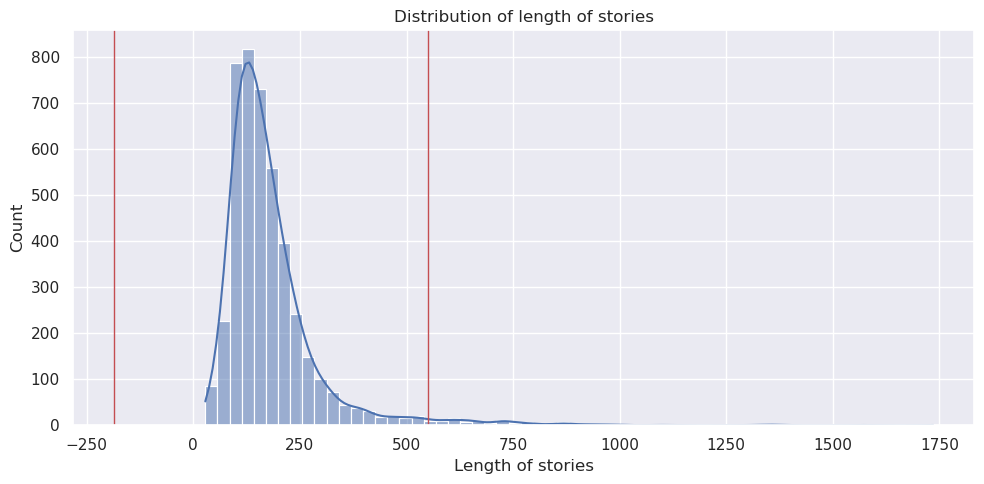

In [16]:
fig, ax = plt.subplots(1, 1, 
                      figsize=(10, 5),
                      tight_layout=True)

df_len['z_score'] = zscore(df_len['word_len'])

# Identify outliers
threshold = 3
df_len['is_outlier'] = df_len['z_score'].abs() > threshold

# Display the outliers
outliers = df_len[df_len['is_outlier']]

# Find the boundary values corresponding to the z-score thresholds
mean_len = np.mean(df_len['word_len'])
std_len = np.std(df_len['word_len'])

lower_bound = mean_len - threshold * std_len # -193.20637504830634
upper_bound = mean_len + threshold * std_len # 550.4593499271076


sns.histplot(df_len, x='word_len', bins=60, kde=True, ax=ax)
ax.set_title('Distribution of length of stories')
ax.set_xlabel('Length of stories')

# Adding vertical lines
plt.axvline(x=lower_bound, color='r', linestyle='-', linewidth=1, label=f'Lower Bound (z=-{threshold})')
plt.axvline(x=upper_bound, color='r', linestyle='-', linewidth=1, label=f'Upper Bound (z={threshold})')

## Flag and Cleaning Treppwire summaryplaintext data

In [16]:
# tpwire.iloc[outliers.index,:]

### 1. Containing more than 1 stories & containg table

In [25]:
df_experiment = tpwire.iloc[outliers.index,:][['summaryplaintext', 'publishdate']].iloc[30:45,]
df_experiment

,summaryplaintext,publishdate
1292,Date Loan Count Loan Balance Realized Losse...,2019-10-04T12:13:43
1300,October Payoff Report: Payoff Rate Plunges on ...,2020-11-06T09:41:04
1306,Date Loan Count Loan Balance Realized Losse...,2020-02-04T09:39:11
1388,Trading Alert: CMBX 6 Mall Loan ExtendedBack i...,2023-12-20T06:30:50
1419,Trading Alert: Midtown Manhattan O...,2022-12-12T06:35:19
1460,May Loss Report: Loss Volume Decreases Dramati...,2023-06-07T23:08:42
1469,TreppWire Trading Alert: Parkmerced Mezz Loan ...,2023-03-03T06:30:30
1497,Four Midwest Hotels Backing 2014 CMBS Loans S...,2021-12-28T09:38:16
1498,WeWork to Shutter Office Space in Burban...,2022-11-08T08:52:22
1506,Date Loan Count Loan Balance Realized Losse...,2019-06-04T12:20:32


In [19]:
# def cal_cost(response):
#     input_token = response.usage.prompt_tokens
#     output_token = response.usage.completion_tokens
    
#     total_cost = input_token * 0.0005 / 1000 + output_token * 0.0015 / 1000
#     return total_cost

In [23]:
start_time = time.time()

num_of_stories, tb_flag, content, num_of_input, num_of_output = [], [], [], 0, 0

for i in range(len(df_experiment)):
    context = df_experiment.iloc[i,:].summaryplaintext
    
    input_text = prompt5.format(context=context)
    
    response = get_completion(input_text)
    
    # cost calculation
    num_of_input += response.usage.prompt_tokens
    num_of_output += response.usage.completion_tokens

    py_response = json.loads(response.choices[0].message.content) # load from json to python objects
    
    num_of_stories.append(len(py_response['context']))
    tb_flag.append(py_response["containing_table"])
    content.append(py_response["context"]) # List of list of dicts, each list of dict is [{'title1': xxx, 'content1': xxx}, {'title2': xxx, 'content2': xxx}]

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")
print(f"Average input tokens: {num_of_input/15}, average output tokens: {num_of_input/15}")

Execution time: 269.39316725730896 seconds
Average input tokens: 1773.5333333333333, average output tokens: 1773.5333333333333


In [55]:
len(tpwire) * (num_of_input * 0.0005 / 1000 / 15 + num_of_output * 0.0015 / 1000 / 15)

12.6212198

In [26]:
df_experiment['num_of_stories'] = num_of_stories
df_experiment['table_flag'] = tb_flag
df_experiment['content'] = content
df_experiment

,summaryplaintext,publishdate,num_of_stories,table_flag,content
1292,Date Loan Count Loan Balance Realized Losse...,2019-10-04T12:13:43,1,False,[{'title': 'Loan Liquidations since January 20...
1300,October Payoff Report: Payoff Rate Plunges on ...,2020-11-06T09:41:04,1,False,[{'title': 'October Payoff Report: Payoff Rate...
1306,Date Loan Count Loan Balance Realized Losse...,2020-02-04T09:39:11,1,True,[{'title': 'Monthly Loan Liquidations – US Fix...
1388,Trading Alert: CMBX 6 Mall Loan ExtendedBack i...,2023-12-20T06:30:50,4,False,[{'title': 'Trading Alert: CMBX 6 Mall Loan Ex...
1419,Trading Alert: Midtown Manhattan O...,2022-12-12T06:35:19,6,False,[{'title': 'Trading Alert: Midtown Manhattan O...
1460,May Loss Report: Loss Volume Decreases Dramati...,2023-06-07T23:08:42,1,True,[{'title': 'May Loss Report: Loss Volume Decre...
1469,TreppWire Trading Alert: Parkmerced Mezz Loan ...,2023-03-03T06:30:30,1,False,[{'title': 'TreppWire Trading Alert: Parkmerce...
1497,Four Midwest Hotels Backing 2014 CMBS Loans S...,2021-12-28T09:38:16,4,False,[{'title': 'Four Midwest Hotels Backing 2014 C...
1498,WeWork to Shutter Office Space in Burban...,2022-11-08T08:52:22,5,False,[{'title': 'WeWork to Shutter Office Space in ...
1506,Date Loan Count Loan Balance Realized Losse...,2019-06-04T12:20:32,1,False,[{'title': 'Loan Liquidations since January 20...


In [30]:
# df_experiment.to_parquet('df_stories.parquet')

In [63]:
# input_text = prompt6.format(context=tpwire.loc[231,:].summaryplaintext)
    
# response = get_completion(input_text)
# print(response.choices[0].message.content)

Pattern: From 2024-01-01, treppstories use ⇨ to indicate the start of each stories.

### 1.* Same thing but with alternative df_experiments (5 single story, 10 multiple stories)

In [27]:
multi_story_lst = [208, 231, 265, 557, 907, 
                   950, 960, 1033, 1072, 1119, 
                   1170, 1262, 1388, 1419, 1497]
single_story_lst = [101, 119, 141, 159, 173]
df_experiment_20 = tpwire.loc[multi_story_lst+single_story_lst,:]
df_experiment_20.head()

,creditstoriesid,postid,authoremail,authorname,contentsource,contenttype,dealname,htmlcontent,summaryplaintext,loanid,...,propertysubtype,propsubtypecode,proptypecode,state,county,city,msaname,loanname,region,publishdate
208,79421cf35ea3c80b609369707d4d8e8cc7b6fa8aa98dc9...,56520,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],"<div id=""content"">\n<div>\n<h4><strong>Big CMB...",Big CMBX 7 Retail Pays Off Ahead of November...,[],...,[],[],[],[],[],[],[],[],[],2023-09-19T09:32:54
231,2c164269bb840747cf837f14cdc9c4e9705db71561e7ff...,55965,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],"<div>\n<div id=""recent-commentary"">\n<div id=""...",Retail Center in St. Louis County ...,[],...,[],[],[],[],[],[],[],[],[],2022-12-09T09:14:19
265,1a98b74d9978a27cd376c9a9348554299632208fd8da93...,55182,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[COMM 2015-LC21],"<div id=""content"">\n<div id=""post-45954"">\n<h4...",Note Sales or Modifications Coming for Two B...,[363761],...,[Urban Office],[Office],[OF],[AK],[Anchorage],[Anchorage],"[Anchorage, AK]",[Anchorage Business Park],[Pacific],2021-11-22T05:19:21
557,4ab8465984b3205d9ec24b80cd9b63d018427ee40c886b...,56593,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[BMARK 2018-B3],"<h4 style=""font-size: 16px; font-weight: norma...",2018 SASB Hotel Loan to Be RetiredA new SASB h...,[337136],...,[Regional Mall],[Retail],[RT],[LA],[Orleans],[New Orleans],"[New Orleans-Metairie, LA]",[The Shops at Canal Place],[West South Central],2023-10-16T06:30:15
907,ea241d825676fb449f9694ca9316ae55814dd5787f0c83...,57194,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[],"<div class=""hse-section"" id=""module_1699994664...",⇨ Manhattan Office Loan Sent to Speci...,[],...,[],[],[],[],[],[],[],[],[],2024-03-20T06:30:02


In [65]:
# df_experiment_20.to_parquet('df_stories_20.parquet')

In [ ]:
start_time = time.time()

num_of_stories, tb_flag, content, num_of_input, num_of_output = [], [], [], 0, 0

for i in range(len(df_experiment_20)):
    context = df_experiment_20.iloc[i,:].summaryplaintext
    
    input_text = prompt5.format(context=context)
    
    response = get_completion(input_text)
    
    # cost calculation
    num_of_input += response.usage.prompt_tokens
    num_of_output += response.usage.completion_tokens

    py_response = json.loads(response.choices[0].message.content) # load from json to python objects
    
    num_of_stories.append(len(py_response['context']))
    tb_flag.append(py_response["containing_table"])
    content.append(py_response["context"]) # List of list of dicts, each list of dict is [{'title1': xxx, 'content1': xxx}, {'title2': xxx, 'content2': xxx}]

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")
print(f"Average input tokens: {num_of_input/15}, average output tokens: {num_of_input/15}")

In [ ]:
df_experiment_20['num_of_stories'] = num_of_stories
df_experiment_20['table_flag'] = tb_flag
df_experiment_20['content'] = content
df_experiment_20

### 2. table flag and multiple stories flag

In [113]:
df_experiment_new = tpwire.iloc[outliers.index,:][['summaryplaintext', 'publishdate']].iloc[30:45,]
df_experiment_new

,summaryplaintext,publishdate
1292,Date Loan Count Loan Balance Realized Losse...,2019-10-04T12:13:43
1300,October Payoff Report: Payoff Rate Plunges on ...,2020-11-06T09:41:04
1306,Date Loan Count Loan Balance Realized Losse...,2020-02-04T09:39:11
1388,Trading Alert: CMBX 6 Mall Loan ExtendedBack i...,2023-12-20T06:30:50
1419,Trading Alert: Midtown Manhattan O...,2022-12-12T06:35:19
1460,May Loss Report: Loss Volume Decreases Dramati...,2023-06-07T23:08:42
1469,TreppWire Trading Alert: Parkmerced Mezz Loan ...,2023-03-03T06:30:30
1497,Four Midwest Hotels Backing 2014 CMBS Loans S...,2021-12-28T09:38:16
1498,WeWork to Shutter Office Space in Burban...,2022-11-08T08:52:22
1506,Date Loan Count Loan Balance Realized Losse...,2019-06-04T12:20:32


In [114]:
start_time = time.time()

multi_story_flag, tb_flag, num_of_input, num_of_output = [], [], 0, 0

for i in range(len(df_experiment)):
    context = df_experiment.iloc[i,:].summaryplaintext
    
    input_text = prompt7.format(context=context)
    
    response = get_completion(input_text)
    
    # cost calculation
    num_of_input += response.usage.prompt_tokens
    num_of_output += response.usage.completion_tokens

    py_response = json.loads(response.choices[0].message.content) # load from json to python objects
    
    multi_story_flag.append(py_response['containing_multiple_stories'])
    tb_flag.append(py_response["containing_table"])

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")
print(f"Average input tokens: {num_of_input/15}, average output tokens: {num_of_output/15}")

Execution time: 8.602037191390991 seconds
Average input tokens: 1844.5333333333333, average output tokens: 20.0


In [115]:
print(f"Total estimate cost is ${len(tpwire) * ((num_of_input/15) * (0.0005 / 1000) + (num_of_output/15) * (0.0015 / 1000)):.2f}")

Total estimate cost is $4.24


In [ ]:
# calc cost, figure out batch API, remove some not important rows. next steps of rag.

In [116]:
df_experiment_new['multi_story_flag'] = multi_story_flag
df_experiment_new['table_flag'] = tb_flag
df_experiment_new

,summaryplaintext,publishdate,multi_story_flag,table_flag
1292,Date Loan Count Loan Balance Realized Losse...,2019-10-04T12:13:43,False,True
1300,October Payoff Report: Payoff Rate Plunges on ...,2020-11-06T09:41:04,False,False
1306,Date Loan Count Loan Balance Realized Losse...,2020-02-04T09:39:11,False,True
1388,Trading Alert: CMBX 6 Mall Loan ExtendedBack i...,2023-12-20T06:30:50,True,False
1419,Trading Alert: Midtown Manhattan O...,2022-12-12T06:35:19,True,False
1460,May Loss Report: Loss Volume Decreases Dramati...,2023-06-07T23:08:42,True,True
1469,TreppWire Trading Alert: Parkmerced Mezz Loan ...,2023-03-03T06:30:30,False,False
1497,Four Midwest Hotels Backing 2014 CMBS Loans S...,2021-12-28T09:38:16,True,False
1498,WeWork to Shutter Office Space in Burban...,2022-11-08T08:52:22,True,False
1506,Date Loan Count Loan Balance Realized Losse...,2019-06-04T12:20:32,False,True


In [110]:
df_experiment

,summaryplaintext,publishdate,num_of_stories,table_flag,content
1292,Date Loan Count Loan Balance Realized Losse...,2019-10-04T12:13:43,1,False,[{'title': 'Loan Liquidations since January 20...
1300,October Payoff Report: Payoff Rate Plunges on ...,2020-11-06T09:41:04,1,False,[{'title': 'October Payoff Report: Payoff Rate...
1306,Date Loan Count Loan Balance Realized Losse...,2020-02-04T09:39:11,1,True,[{'title': 'Monthly Loan Liquidations – US Fix...
1388,Trading Alert: CMBX 6 Mall Loan ExtendedBack i...,2023-12-20T06:30:50,4,False,[{'title': 'Trading Alert: CMBX 6 Mall Loan Ex...
1419,Trading Alert: Midtown Manhattan O...,2022-12-12T06:35:19,6,False,[{'title': 'Trading Alert: Midtown Manhattan O...
1460,May Loss Report: Loss Volume Decreases Dramati...,2023-06-07T23:08:42,1,True,[{'title': 'May Loss Report: Loss Volume Decre...
1469,TreppWire Trading Alert: Parkmerced Mezz Loan ...,2023-03-03T06:30:30,1,False,[{'title': 'TreppWire Trading Alert: Parkmerce...
1497,Four Midwest Hotels Backing 2014 CMBS Loans S...,2021-12-28T09:38:16,4,False,[{'title': 'Four Midwest Hotels Backing 2014 C...
1498,WeWork to Shutter Office Space in Burban...,2022-11-08T08:52:22,5,False,[{'title': 'WeWork to Shutter Office Space in ...
1506,Date Loan Count Loan Balance Realized Losse...,2019-06-04T12:20:32,1,False,[{'title': 'Loan Liquidations since January 20...


In [42]:
input_text = prompt6.format(context=tpwire.loc[1506,:].summaryplaintext)
    
response = get_completion(input_text)
json.loads(response.choices[0].message.content)

{'containing_multiple_stories': False, 'containing_table': True}

In [111]:
tpwire.loc[1506,:].summaryplaintext

'   Date Loan Count Loan Balance Realized Losses Loss Severity   January-10 63 549,384,706 200,129,914 36   February-10 56 429,184,346 117,406,019 27   March-10 87 622,195,209 178,539,422 29   April-10 120 803,904,962 330,742,525 41   May-10 112 649,221,069 282,798,257 44   June-10 111 624,636,270 291,731,417 47   July-10 220 1,363,797,447 723,119,835 53   August-10 210 1,178,423,281 681,465,121 58   September-10 91 809,983,612 449,080,314 55   October-10 98 990,213,691 304,368,692 31   November-10 107 784,385,931 306,962,114 39   December-10 196 1,168,111,160 641,874,077 55   January-11 189 1,513,598,631 582,873,718 39   February-11 106 814,934,396 292,236,510 36   March-11 105 1,211,303,756 215,579,668 18   April-11 175 1,240,232,661 494,977,896 40   May-11 148 1,376,005,120 594,056,258 43   June-11 197 1,803,572,607 836,829,170 46   July-11 175 1,338,268,568 537,544,059 40   August-11 159 1,012,636,864 505,394,273 50   September-11 141 1,263,542,333 573,364,777 45   October-11 112 9

## Batch API

In [65]:
df_experiment_new = tpwire.iloc[outliers.index,:][['summaryplaintext', 'publishdate']].iloc[30:45,]
df_experiment_new

,summaryplaintext,publishdate
1292,Date Loan Count Loan Balance Realized Losse...,2019-10-04T12:13:43
1300,October Payoff Report: Payoff Rate Plunges on ...,2020-11-06T09:41:04
1306,Date Loan Count Loan Balance Realized Losse...,2020-02-04T09:39:11
1388,Trading Alert: CMBX 6 Mall Loan ExtendedBack i...,2023-12-20T06:30:50
1419,Trading Alert: Midtown Manhattan O...,2022-12-12T06:35:19
1460,May Loss Report: Loss Volume Decreases Dramati...,2023-06-07T23:08:42
1469,TreppWire Trading Alert: Parkmerced Mezz Loan ...,2023-03-03T06:30:30
1497,Four Midwest Hotels Backing 2014 CMBS Loans S...,2021-12-28T09:38:16
1498,WeWork to Shutter Office Space in Burban...,2022-11-08T08:52:22
1506,Date Loan Count Loan Balance Realized Losse...,2019-06-04T12:20:32


In [66]:
batch_file = generate_tasks(df_experiment_new, task_file_name="./batch_tasks_movies.jsonl")

100%|██████████| 15/15 [00:00<00:00, 13349.15it/s]


In [67]:
batch_file

FileObject(id='file-iiJXjeqQg9rR1bMsLeRTtn5I', bytes=105253, created_at=1720466850, filename='batch_tasks_movies.jsonl', object='file', purpose='batch', status='processed', status_details=None)

In [68]:
batch_job = create_batch_job(batch_file)

In [75]:
batch_job = client.batches.retrieve(batch_job.id)
batch_job

Batch(id='batch_7HR3L2KyAWlONfjX6Q4PyLap', completion_window='24h', created_at=1720466859, endpoint='/v1/chat/completions', input_file_id='file-iiJXjeqQg9rR1bMsLeRTtn5I', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1720466923, error_file_id=None, errors=None, expired_at=None, expires_at=1720553259, failed_at=None, finalizing_at=1720466922, in_progress_at=1720466860, metadata=None, output_file_id='file-sIIeR56op4P824bm6MVrAKbZ', request_counts=BatchRequestCounts(completed=15, failed=0, total=15))

In [78]:
retrieve_results(batch_job, output_file_name="./batch_job_results_movies.jsonl")

In [101]:
multi_story_flag, tb_flag, num_of_input, num_of_output = reading_results(output_file_name="./batch_job_results_movies.jsonl")

100%|██████████| 15/15 [00:00<00:00, 116508.44it/s]


In [107]:
print(f"Total estimate cost is ${(num_of_input * (0.0005 / 1000) + num_of_output * (0.0015 / 1000)):.2f}")

Total estimate cost is $0.01


In [61]:
df_experiment_new['multi_story_flag'] = multi_story_flag
df_experiment_new['table_flag'] = tb_flag

In [62]:
df_experiment_new

,summaryplaintext,publishdate,multi_story_flag,table_flag
1292,Date Loan Count Loan Balance Realized Losse...,2019-10-04T12:13:43,False,True
1300,October Payoff Report: Payoff Rate Plunges on ...,2020-11-06T09:41:04,False,False
1306,Date Loan Count Loan Balance Realized Losse...,2020-02-04T09:39:11,False,True
1388,Trading Alert: CMBX 6 Mall Loan ExtendedBack i...,2023-12-20T06:30:50,True,False
1419,Trading Alert: Midtown Manhattan O...,2022-12-12T06:35:19,True,False
1460,May Loss Report: Loss Volume Decreases Dramati...,2023-06-07T23:08:42,True,True
1469,TreppWire Trading Alert: Parkmerced Mezz Loan ...,2023-03-03T06:30:30,False,False
1497,Four Midwest Hotels Backing 2014 CMBS Loans S...,2021-12-28T09:38:16,True,False
1498,WeWork to Shutter Office Space in Burban...,2022-11-08T08:52:22,True,False
1506,Date Loan Count Loan Balance Realized Losse...,2019-06-04T12:20:32,False,True


## Data Cleaning: Formal process for whole data

In [108]:
# tpwire = pd.read_parquet('treppwire_stories.parquet')
# tpwire = load_s3_parquet('treppwire_stories.parquet')
# lst = [length >= 28 for length in list_of_word_len(tpwire['summaryplaintext'])]
# tpwire = tpwire[lst]
# tpwire

,creditstoriesid,postid,authoremail,authorname,contentsource,contenttype,dealname,htmlcontent,summaryplaintext,loanid,...,propertysubtype,propsubtypecode,proptypecode,state,county,city,msaname,loanname,region,publishdate
0,609386dc86f2df503086dcceef93c9300e0eb97e23dd6d...,55990,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[UBSBB 2013-C6],<h4><strong>379-Unit Apartment Community in Sa...,379-Unit Apartment Community in San Diego Sold...,[319004],...,[Flex / R&D],[Office],[OF],[PA],[Washington],[Canonsburg],"[Pittsburgh, PA]",[701 Technology Drive],[Middle Atlantic],2022-12-21T06:35:33
1,a244c33053ebd629538df7addfdd7846c3f154a804a461...,56518,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[WFRBS 2014-C20],<h4>Denver Office Misses Balloon Date – Note S...,Denver Office Misses Balloon Date – Note Sent ...,[341601],...,[Suburban Office],[Office],[OF],[TX],[Fort Bend],[Sugar Land],"[Houston-The Woodlands-Sugar Land, TX]","[Sugar Creek I, Sugar Creek II]",[West South Central],2023-09-18T09:27:20
2,713bc661ed6e8aad6987dbf54d0f41a6881847e382b04e...,56147,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[UBSBM 2012-WRM],<h4><strong>TreppWire News Flash: New Special ...,TreppWire News Flash: New Special Servicer Com...,[338547],...,[Mixed Use],[Mixed Use],[MU],[GA],[Fulton],[Atlanta],"[Atlanta-Sandy Springs-Roswell, GA]",[Biltmore Office],[South Atlantic],2023-03-13T06:30:56
3,22a75dc8781ff52b1cd2994b35b35a64bff0482d681d70...,56384,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[OMPT 2017-1MKT],<h4><strong>Big TX Retail Loan Paid Off</stron...,Big TX Retail Loan Paid OffJuly remittance dat...,[398221],...,[Urban Office],[Office],[OF],[CA],[San Francisco],[San Francisco],"[San Francisco-Oakland-Hayward, CA]",[One Market Plaza],[Pacific],2023-07-20T09:33:49
4,1ae4bebc08a10939c40e4ecf663897f107600c3e58361e...,55950,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[CSAIL 2018-C14],<h4><strong>Age Restricted Community Behind CM...,Age Restricted Community Behind CMBX 15 Loan S...,[439692],...,[Suburban Office],[Office],[OF],[IL],[Cook],[Rolling Meadows],"[Chicago-Naperville-Elgin, IL-IN-WI]",[Continental Towers],[East North Central],2022-12-05T09:09:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4533,95a94709c55a7a3924d54c4730ddcab88a16bd1935316a...,55411,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[FREMF 2020-KF83],<h4><strong>Glendale Apartment Complex Sold Fo...,Glendale Apartment Complex Sold For Almost 20%...,[312925],...,[Urban Office],[Office],[OF],[NY],[New York],[New York],"[New York-Newark-Jersey City, NY-NJ-PA]",[520 Eighth Avenue],[Middle Atlantic],2022-04-07T09:21:42
4534,95132cd5309ce7dd10acd2e91ad94fcb0ff4c3c5af5f41...,52950,mclancy@trepp.com,Manus Clancy,TreppWire,post,[COMM 2005-LP5],"<h4><span style=""color: #000000;""><strong>Foll...",Follow-up: Value of Michigan Mall Behind 2015 ...,[317429],...,[Extended Stay],[Hospitality],[LO],[NY],[Erie],[Buffalo],"[Buffalo-Cheektowaga-Niagara Falls, NY]",[Residence Inn - Buffalo],[Middle Atlantic],2019-05-15T08:58:20
4535,b5a7447f9084de713c3d612a336c8214c2b224d0d1b279...,53047,mclancy@trepp.com,Manus Clancy,TreppWire,post,[FREMF 2014-K41],"<h4><span style=""color: #000000;""><strong>Denv...",Denver Multifamily Trades for $62 MillionMile ...,[417235],...,[Suburban Office],[Office],[OF],[VA],[Arlington],[Arlington],"[Washington-Arlington-Alexandria, DC-VA-MD-WV]",[Presidential Tower],[South Atlantic],2019-05-22T08:55:36
4536,73fe483a2e251c43c87ae68c517f4f07c05db393a1fbed...,55831,hayley_keen@trepp.com,Hayley Keen,TreppWire,post,[UBSCM 2017-C3],<h4><strong>Follow-Up: PA Mall Loan Extended</...,"Follow-Up: PA Mall Loan ExtendedIn August, we ...",[407395],...,[Urban Office],[Office],[OF],[GA],[Fulton],[Atlanta],"[Atlanta-Sandy Springs-Roswell, GA]",[American Cancer Society Center],[South Atlantic],2022-10-19T08:55:03


In [146]:
# batch_file = generate_tasks(tpwire, task_file_name="./batch_flag_tasks.jsonl")

100%|██████████| 4449/4449 [00:00<00:00, 8624.75it/s] 


In [147]:
# batch_file

FileObject(id='file-fn1rcHCusdwgOZjyDM4Yn1SK', bytes=13985786, created_at=1720470182, filename='batch_flag_tasks.jsonl', object='file', purpose='batch', status='processed', status_details=None)

In [148]:
# start_time = time.time()

# batch_job = create_batch_job(batch_file)

# end_time = time.time()
# execution_time = end_time - start_time
# print(f"Execution time: {execution_time} seconds")

Execution time: 0.31461095809936523 seconds


16:23 - 16:35

In [162]:
# batch_job = client.batches.retrieve(batch_job.id)
# batch_job

Batch(id='batch_ggBt7m2legDCznWzt4817sK0', completion_window='24h', created_at=1720470184, endpoint='/v1/chat/completions', input_file_id='file-fn1rcHCusdwgOZjyDM4Yn1SK', object='batch', status='completed', cancelled_at=None, cancelling_at=None, completed_at=1720470868, error_file_id=None, errors=None, expired_at=None, expires_at=1720556584, failed_at=None, finalizing_at=1720470693, in_progress_at=1720470188, metadata=None, output_file_id='file-FS0ufPG2MI1n7RnZ4ifOYprj', request_counts=BatchRequestCounts(completed=4449, failed=0, total=4449))

In [163]:
# retrieve_results(batch_job, output_file_name="./batch_flag_job_results.jsonl")

In [164]:
# multi_story_flag, tb_flag, num_of_input, num_of_output = reading_results(output_file_name="./batch_flag_job_results.jsonl")

100%|██████████| 4449/4449 [00:00<00:00, 327813.55it/s]


In [165]:
# print(f"Total estimate cost is ${(num_of_input * (0.0005 / 1000) + num_of_output * (0.0015 / 1000)):.2f}")

Total estimate cost is $1.57


In [167]:
# tpwire['multi_story_flag'] = multi_story_flag
# tpwire['table_flag'] = tb_flag

In [178]:
# tpwire.head(20)

In [168]:
# tpwire.to_parquet('tpwire_flags.parquet')

In [179]:
final_df = load_s3_parquet("tpwire_flags.parquet")[['summaryplaintext', 'publishdate', 'multi_story_flag', 'table_flag']]

In [180]:
final_df

,summaryplaintext,publishdate,multi_story_flag,table_flag
0,379-Unit Apartment Community in San Diego Sold...,2022-12-21T06:35:33,False,False
1,Denver Office Misses Balloon Date – Note Sent ...,2023-09-18T09:27:20,False,False
2,TreppWire News Flash: New Special Servicer Com...,2023-03-13T06:30:56,False,False
3,Big TX Retail Loan Paid OffJuly remittance dat...,2023-07-20T09:33:49,False,False
4,Age Restricted Community Behind CMBX 15 Loan S...,2022-12-05T09:09:56,False,False
...,...,...,...,...
4533,Glendale Apartment Complex Sold For Almost 20%...,2022-04-07T09:21:42,False,False
4534,Follow-up: Value of Michigan Mall Behind 2015 ...,2019-05-15T08:58:20,False,False
4535,Denver Multifamily Trades for $62 MillionMile ...,2019-05-22T08:55:36,False,False
4536,"Follow-Up: PA Mall Loan ExtendedIn August, we ...",2022-10-19T08:55:03,False,False


In [181]:
final_df = final_df[(final_df['multi_story_flag'] == False) & (final_df['table_flag'] == False)]
final_df

,summaryplaintext,publishdate,multi_story_flag,table_flag
0,379-Unit Apartment Community in San Diego Sold...,2022-12-21T06:35:33,False,False
1,Denver Office Misses Balloon Date – Note Sent ...,2023-09-18T09:27:20,False,False
2,TreppWire News Flash: New Special Servicer Com...,2023-03-13T06:30:56,False,False
3,Big TX Retail Loan Paid OffJuly remittance dat...,2023-07-20T09:33:49,False,False
4,Age Restricted Community Behind CMBX 15 Loan S...,2022-12-05T09:09:56,False,False
...,...,...,...,...
4533,Glendale Apartment Complex Sold For Almost 20%...,2022-04-07T09:21:42,False,False
4534,Follow-up: Value of Michigan Mall Behind 2015 ...,2019-05-15T08:58:20,False,False
4535,Denver Multifamily Trades for $62 MillionMile ...,2019-05-22T08:55:36,False,False
4536,"Follow-Up: PA Mall Loan ExtendedIn August, we ...",2022-10-19T08:55:03,False,False


In [18]:
# load_s3_parquet("tpwire_flags.parquet")